# Stochastic Declustering Model
Non-parametrically estimate the background intensity and estimate the self-exciting parameters. The specific parametric form is given below.
\begin{equation}
\lambda(x,y,t) = \mu(x,y) + \sum_{i:t>t_i}{r_0 f(t-t_i;\beta) \varphi(x;x_i,\sigma_1) \varphi(y;y_i,\sigma_2)}
\end{equation}
where $\varphi$ is the normal density and $f$ is the exponential density.

In [1]:
from sklearn.neighbors import KernelDensity
from scipy.stats import norm, expon
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool
from functools import partial
import pandas as pd
from datetime import datetime

In [2]:
from sd_no_marks import *

In [2]:
from stochastic_declustering import *

# Simulated Data

In [3]:
def gen_dat(par,T):
    r_0, b, sigma_1, sigma_2 = par
    n_bg = np.random.poisson(250,size=1)
    bg = np.stack((np.random.normal(size=n_bg),np.random.normal(size=n_bg),np.random.uniform(size=n_bg)*T)).T
    i = 0
    while i < len(bg):
        for j in range(np.random.poisson(lam=r_0)):
            bg = np.concatenate((bg,[bg[i]+[np.random.normal(scale=sigma_1), 
                                           np.random.normal(scale=sigma_2), 
                                           np.random.exponential(b)]]))
        i += 1
    return bg
par = np.array([.5,1,.1,.1])
events = gen_dat(par,200)
len(events)

495

In [4]:
par_0 = par + np.random.normal(scale=par/4,size=4)
sd = stochastic_declustering(events,T=200)
sd.fit(par_0)

Optimization terminated successfully.
         Current function value: 687.354197
         Iterations: 89
         Function evaluations: 161
MLE time 21.915916681289673
Finished MLE
[0.50000209 1.0032404  0.09528197 0.10137532]
Change in parameters: 0.0303052489161757
Optimization terminated successfully.
         Current function value: 661.814647
         Iterations: 80
         Function evaluations: 145
MLE time 30.783464431762695
Finished MLE
[0.48374895 0.9547608  0.09333472 0.09949887]
Change in parameters: 0.0026217490431495027
Optimization terminated successfully.
         Current function value: 652.102778
         Iterations: 70
         Function evaluations: 125
MLE time 27.09359073638916
Finished MLE
[0.48093502 0.9484699  0.09300879 0.09908252]
Change in parameters: 4.7773222478959414e-05


array([0.48093502, 0.9484699 , 0.09300879, 0.09908252])

In [5]:
import pickle
with open('simulated_sd.o','wb') as f:
    pickle.dump(sd,f)

In [3]:
import pickle
with open('simulated_sd.o','rb') as f:
    sd = pickle.load(f)

In [4]:
S = sd.wald()

In [10]:
from scipy.stats import chi2
par_names = ['r_0','b','s1','s2']
i = 3
p_val = 1-chi2.cdf((sd.parameters[i])**2/S[i,i],1)
MOE = (chi2.ppf(0.975,1)*S[i,i])**0.5
CI = (sd.parameters[i]-MOE,sd.parameters[i]+MOE)
print(f"p-value for (H_0: {par_names[i]}=0):{p_val}.\nConfidence interval for {par_names[i]}: {CI}")

p-value for (H_0: s2=0):0.0.
Confidence interval for s2: (0.08537931004061607, 0.11278573678987906)


### Model Checking: Spatial

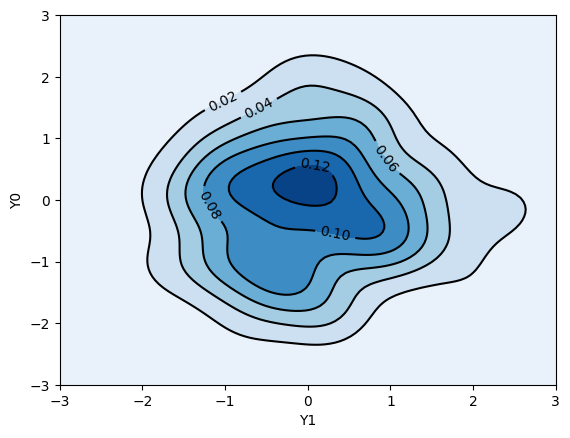

In [11]:
sd.plot_background()

In [6]:
super_thinned = sd.super_thinning(250/10/sd.T,A = [[-3,3],[-3,3]])

Number of simulated points, 625.
 Number of data points 252


In [7]:
z, p = csr_mnn_test(super_thinned,[[-3,3],[-3,3]])

Mean Nearest Neighbor Complete Spatial Randomness Test on Super Thinned Points
Z-value: 0.19922579192535633, P-value: 0.8420861247641829


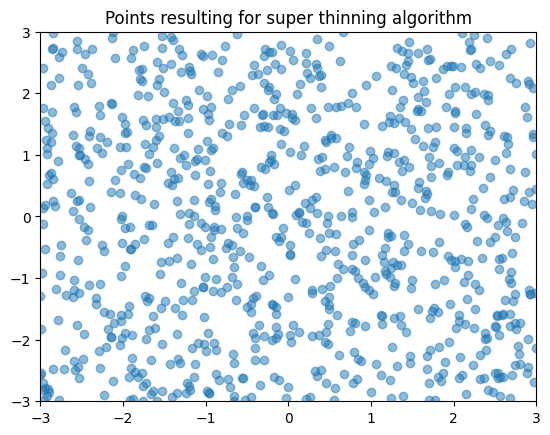

In [8]:
plt.scatter(super_thinned.T[0],super_thinned.T[1],alpha=.5)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title("Points resulting for super thinning algorithm")
plt.show()

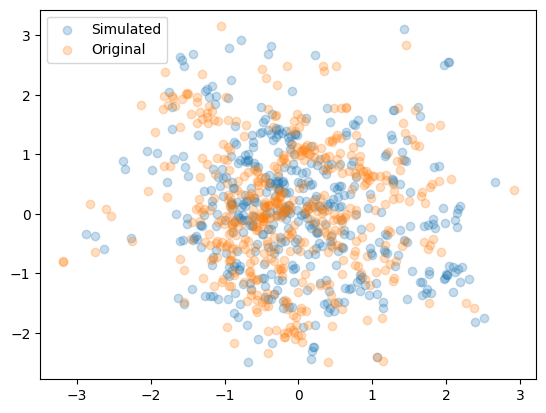

In [9]:
sim = sd.simulate()
plt.scatter(sim.T[0],sim.T[1],alpha=0.25,label='Simulated')
plt.scatter(events.T[0],events.T[1],alpha=0.25,label='Original')
plt.legend()
plt.show()

### Model Checking: Temporal

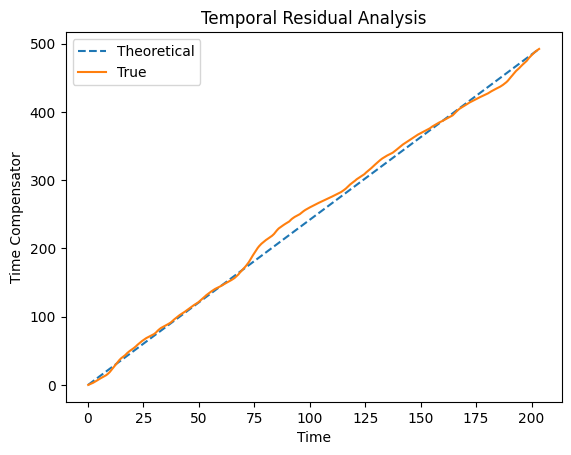

In [10]:
t = np.sort(sd.events.T[2].copy())
t_resid = sd.Lamb_t(t)
plt.plot(t,t*t_resid[-1]/t[-1],linestyle='dashed',label="Theoretical")
plt.plot(t,t_resid,label="True")
plt.ylabel("Time Compensator")
plt.xlabel("Time")
plt.legend()
plt.title("Temporal Residual Analysis")
plt.show()

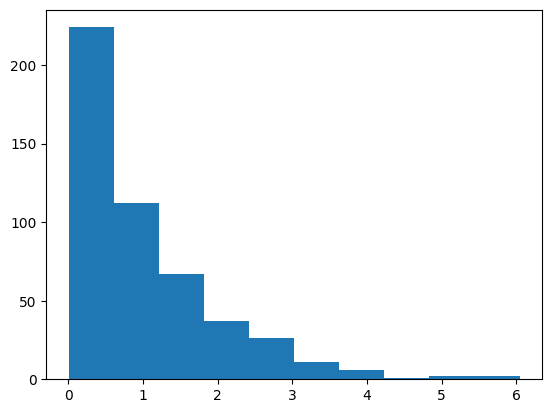

KstestResult(statistic=0.023459205241938896, pvalue=0.9452413013732593, statistic_location=0.9887737994171513, statistic_sign=-1)

In [11]:
from scipy.stats import kstest
iet = t_resid[1:]-t_resid[:-1]
plt.hist(iet)
plt.show()
kstest(iet,expon.cdf)

# Earthquake Dataset

In [4]:
data = pd.read_csv('../Data/earthquake_data.csv')
data['time'] = data.date_time.apply(lambda x: datetime.strptime(x,'%d-%m-%Y %H:%M').timestamp())
T = data.time.min()
data['time'] = (data['time']-T)/(60*60*24)
T = data.time.max()

In [24]:
date = data.date_time.apply(lambda x: datetime.strptime(x,'%d-%m-%Y %H:%M'))
data['date'] = date.apply(lambda x: x.strftime("%Y-%m-%d"))
data['hour'] = date.apply(lambda x: x.strftime("%H"))
data_ready = data[['longitude','latitude','time','date','hour']].sort_values('time').copy()
data_ready.columns = ['X','Y','T','date','hour']

In [26]:
data_ready.to_csv("Filtered_Earthquake.csv",index=False)

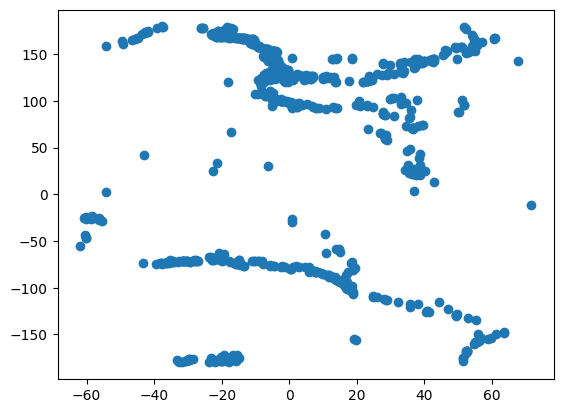

In [6]:
X = data[['latitude','longitude','time']].values
plt.scatter(X.T[0],X.T[1])
plt.show()

In [23]:
par_0 = np.array([0.11758204, 0.73618233, 0.24728506, 0.2743697 ])
sd = stochastic_declustering(X,T=T)
sd.fit(par_0,A=[[-60,60],[-150,150]])

Optimization terminated successfully.
         Current function value: 8719.712153
         Iterations: 242
         Function evaluations: 423
MLE time 68.00182962417603
Finished MLE
[6.39612417e-01 7.85972929e+02 7.14965756e-01 7.90197341e-01]
Change in parameters: 616597.505956893
Optimization terminated successfully.
         Current function value: 8960.623520
         Iterations: 138
         Function evaluations: 260
MLE time 53.01154589653015
Finished MLE
[7.11727596e-01 8.53592281e+02 8.59023690e-01 9.13073690e-01]
Change in parameters: 4572.41784177812
Optimization terminated successfully.
         Current function value: 9008.845583
         Iterations: 124
         Function evaluations: 230
MLE time 46.126052379608154
Finished MLE
[7.27656750e-01 8.69210193e+02 8.94797513e-01 9.41705707e-01]
Change in parameters: 243.92151700507603
Optimization terminated successfully.
         Current function value: 9021.358157
         Iterations: 110
         Function evaluations: 222
ML

In [26]:
import pickle
with open('earthquake_sd.o','wb') as f:
    pickle.dump(sd,f)

In [13]:
import pickle
with open('earthquake_sd.o','rb') as f:
    sd = pickle.load(f)

### Model Checking: Spatial

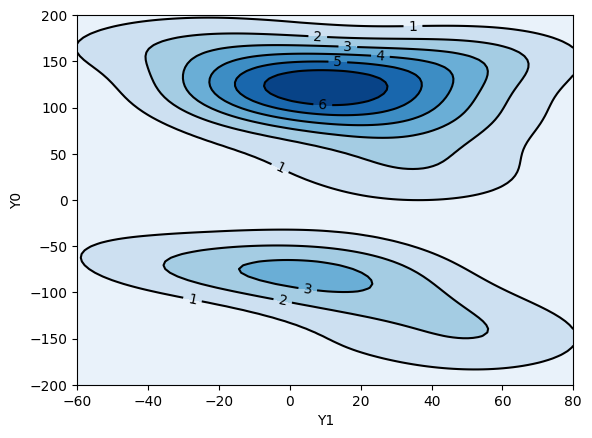

In [11]:
sd.plot_background([[-60,80],[-200,200]])

In [14]:
eq_st = sd.super_thinning(k=.01/sd.T, A=[[-60,80],[-180,200]])

Number of simulated points, 337.
 Number of data points 216


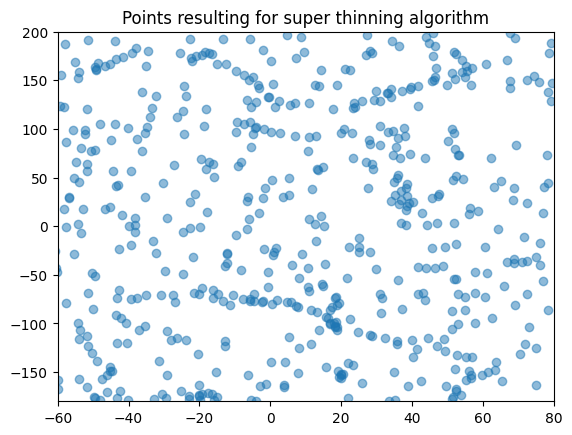

In [15]:
plt.scatter(eq_st.T[0],eq_st.T[1],alpha=.5)
plt.xlim(-60,80)
plt.ylim(-180,200)
plt.title("Points resulting for super thinning algorithm")
plt.show()

In [16]:
#Is the result of thinning completely spatially random?
csr_mnn_test(eq_st,[[-60,80],[-180,200]])

Mean Nearest Neighbor Complete Spatial Randomness Test on Super Thinned Points
Z-value: -3.770988287347834, P-value: 0.0001626023057450333


(-3.770988287347834, 0.0001626023057450333)

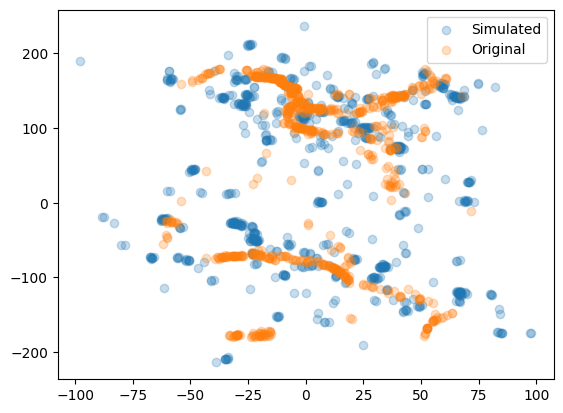

In [18]:
x = sd.simulate()
plt.scatter(x.T[0],x.T[1],alpha=0.25,label='Simulated')
plt.scatter(sd.events.T[0],sd.events.T[1],alpha=0.25,label='Original')
plt.legend()
plt.show()

### Model Checking: Temporal

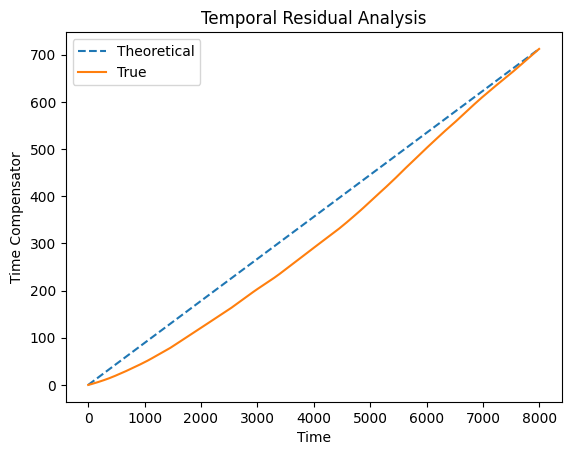

In [19]:
t = np.sort(sd.events.T[2].copy())
t_resid = sd.Lamb_t(t)
plt.plot(t,t*t_resid[-1]/t[-1],linestyle='dashed',label="Theoretical")
plt.plot(t,t_resid,label="True")
plt.ylabel("Time Compensator")
plt.xlabel("Time")
plt.legend()
plt.title("Temporal Residual Analysis")
plt.show()

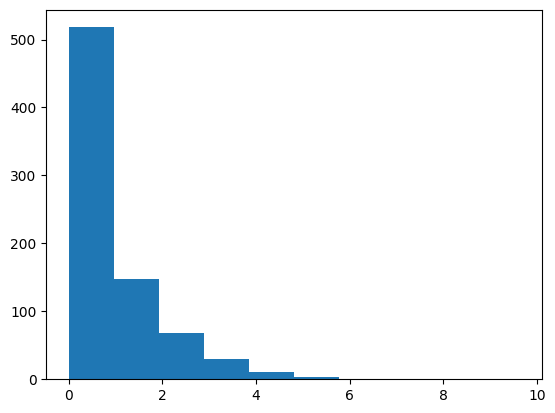

KstestResult(statistic=0.11914083960982166, pvalue=4.0683671250142875e-10, statistic_location=0.10657195375470963, statistic_sign=1)

In [20]:
from scipy.stats import kstest
iet = t_resid[1:]-t_resid[:-1]
plt.hist(iet)
plt.show()
kstest(iet,expon.cdf)

# Global Terrorism Data
Data Source: https://www.kaggle.com/datasets/START-UMD/gtd

In [123]:
data = pd.read_csv('../Data/TerrorismData/globalterrorismdb_0718dist.csv',encoding= "ISO-8859-1")

/tmp/ipykernel_159523/645747709.py:1: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('TerrorismData/globalterrorismdb_0718dist.csv',encoding= "ISO-8859-1")


524


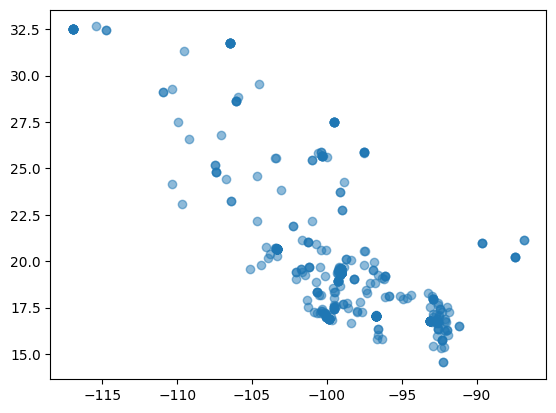

In [124]:
mask = data.country_txt=='Mexico'

subset = data[mask].reset_index()
print(mask.sum())

subset['date'] = pd.Series(subset.index).apply(
    lambda i: (
        datetime(
            subset.loc[i,'iyear'],
            subset.loc[i,'imonth'] if subset.loc[i,'imonth'] != 0 else 1,
            subset.loc[i,'iday'] if subset.loc[i,'iday'] != 0 else 1
        )
    )
)
subset['timestamp'] = subset.date.apply(lambda x: x.timestamp()/(24*60*60))

X = subset.loc[~subset['latitude'].isna(),['longitude','latitude','timestamp']].values
plt.scatter(X.T[0],X.T[1],alpha=.5)
plt.show()

In [125]:
X.T[0] = X.T[0] + np.random.normal(scale=4/69,size=len(X))
X.T[1] = X.T[1] + np.random.normal(scale=4/69,size=len(X))

In [126]:
par_0 = np.array([0.25, 3, 0.1, 0.1])
sd = stochastic_declustering(X,T=T)
sd.fit(par_0,A=[[-116,-90],[15,32]])

Optimization terminated successfully.
         Current function value: 3405.403186
         Iterations: 259
         Function evaluations: 446
MLE time 65.63430094718933
Finished MLE
[6.7630706e-01 7.8349845e+02 6.7848957e-02 7.8068111e-02]
Change in parameters: 609178.0133697335
Optimization terminated successfully.
         Current function value: 3258.587030
         Iterations: 130
         Function evaluations: 249
MLE time 51.956528186798096
Finished MLE
[6.38720677e-01 6.76417117e+02 6.30313324e-02 7.24464516e-02]
Change in parameters: 11466.413315204056
Optimization terminated successfully.
         Current function value: 3236.316149
         Iterations: 121
         Function evaluations: 233
MLE time 45.40640425682068
Finished MLE
[6.32061903e-01 6.56734323e+02 6.23851140e-02 7.17989825e-02]
Change in parameters: 387.41242062220493
Optimization terminated successfully.
         Current function value: 3232.691886
         Iterations: 116
         Function evaluations: 219
MLE

In [127]:
import pickle
with open('mexico_sd.o','wb') as f:
    pickle.dump(sd,f)

In [115]:
import pickle
with open('mexico_sd.o','rb') as f:
    sd = pickle.load(f)

### Model Checking: Spatial

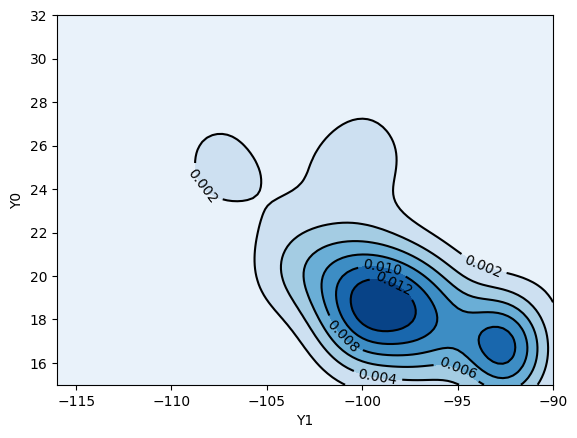

In [130]:
sd.plot_background([[-116,-90],[15,32]])

In [144]:
mex_st = sd.super_thinning(k=1.92/sd.T, A=[[-116,-90],[15,32]])

Number of simulated points, 736.
 Number of data points 191


In [145]:
csr_mnn_test(mex_st,[[-116,-90],[15,32]])

Mean Nearest Neighbor Complete Spatial Randomness Test on Super Thinned Points
Z-value: -2.229316104049952, P-value: 0.02579287988835433


(-2.229316104049952, 0.02579287988835433)

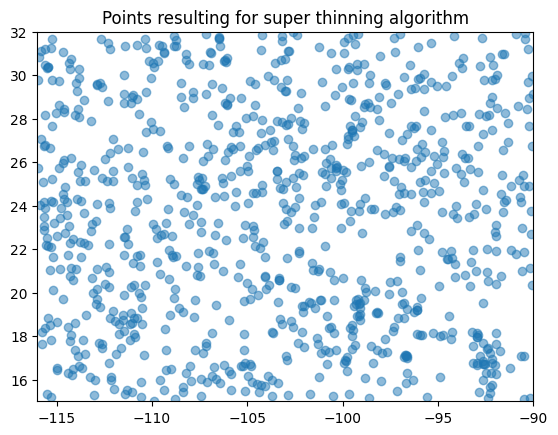

In [146]:
plt.scatter(mex_st.T[0],mex_st.T[1],alpha=.5)
plt.xlim(-116,-90)
plt.ylim(15,32)
plt.title("Points resulting for super thinning algorithm")
plt.show()

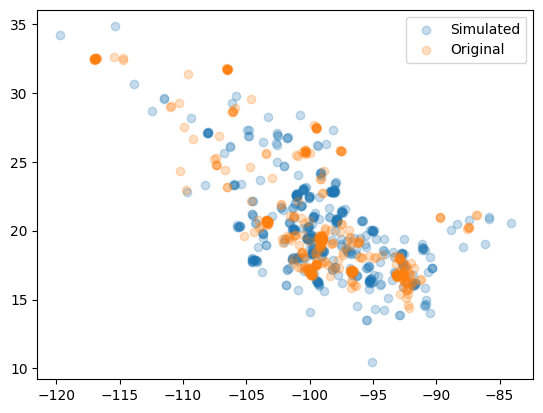

In [148]:
x = sd.simulate()
plt.scatter(x.T[0],x.T[1],alpha=0.25,label='Simulated')
plt.scatter(sd.events.T[0],sd.events.T[1],alpha=0.25,label='Original')
plt.legend()
plt.show()

### Model Checking: Temporal

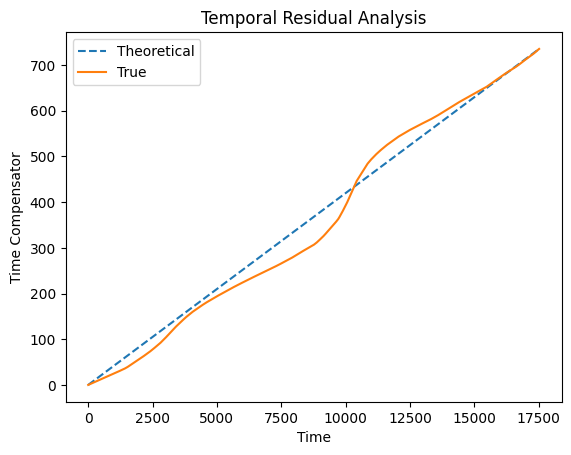

In [116]:
t = np.sort(sd.events.T[2].copy())
t_resid = sd.Lamb_t(t)
plt.plot(t,t*t_resid[-1]/t[-1],linestyle='dashed',label="Theoretical")
plt.plot(t,t_resid,label="True")
plt.ylabel("Time Compensator")
plt.xlabel("Time")
plt.legend()
plt.title("Temporal Residual Analysis")
plt.show()

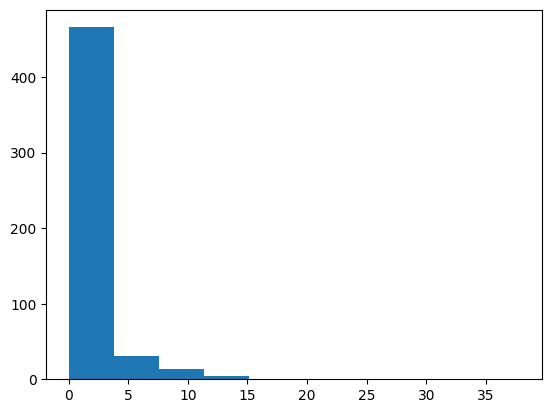

KstestResult(statistic=0.2519230769230769, pvalue=1.431055433306121e-29, statistic_location=0.0, statistic_sign=1)

In [117]:
from scipy.stats import kstest
iet = t_resid[1:]-t_resid[:-1]
plt.hist(iet)
plt.show()
kstest(iet,expon.cdf)

# Boko Haram Terrorist Attacks

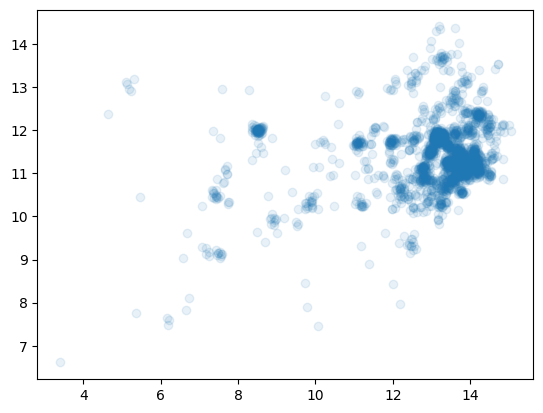

In [3]:
dat = pd.read_csv('../Data/BH_violence.csv')
bh = "Jama'atu Ahlis Sunna Lidda'awati wal-Jihad"
X = dat[['longitude','latitude','date_start']].values
X.T[0] = X.T[0] + np.random.normal(scale=4/69,size=len(X))
X.T[1] = X.T[1] + np.random.normal(scale=4/69,size=len(X))
X = X.astype(float)
plt.scatter(X.T[0],X.T[1],alpha=0.1)
plt.show()

In [4]:
par_0 = np.array([.8,2.75,.1,.1])
T = X.T[2].max()
sd = stochastic_declustering(X,T=T)
sd.fit(par_0,A=[[4,15],[6,14]])

Optimization terminated successfully.
         Current function value: -2503.791233
         Iterations: 130
         Function evaluations: 223
MLE time 95.74328589439392
Finished MLE
[0.83904559 2.762221   0.06977765 0.06720061]
Change in parameters: 0.003663101506951622
Optimization terminated successfully.
         Current function value: -2284.365738
         Iterations: 87
         Function evaluations: 156
MLE time 81.86942386627197
Finished MLE
[0.84621578 2.88817339 0.0695409  0.06839539]
Change in parameters: 0.015916899888248893
Optimization terminated successfully.
         Current function value: -2270.550345
         Iterations: 69
         Function evaluations: 130
MLE time 69.63935828208923
Finished MLE
[0.84613046 2.90882988 0.06942116 0.06850203]
Change in parameters: 0.0004267238539318288


array([0.84613046, 2.90882988, 0.06942116, 0.06850203])

In [ ]:
import pickle
with open('bokoharam_sd.o','wb') as f:
    pickle.dump(sd,f)

In [21]:
import pickle
with open('bokoharam_sd.o','rb') as f:
    sd = pickle.load(f)

In [27]:
S = sd.wald()

In [32]:
from scipy.stats import chi2
par_names = ['r_0','b','s1','s2']
i = 0
p_val = 1-chi2.cdf((sd.parameters[i])**2/S[i,i],1)
MOE = (chi2.ppf(0.975,1)*S[i,i])**0.5
CI = (sd.parameters[i]-MOE,sd.parameters[i]+MOE)
print(f"p-value for (H_0: {par_names[i]}=0):{p_val}.\nConfidence interval for {par_names[i]}: {CI}")

p-value for (H_0: r_0=0):0.0.
Confidence interval for r_0: (0.8020113887321547, 0.8875485312779996)


### Model Checking: Spatial

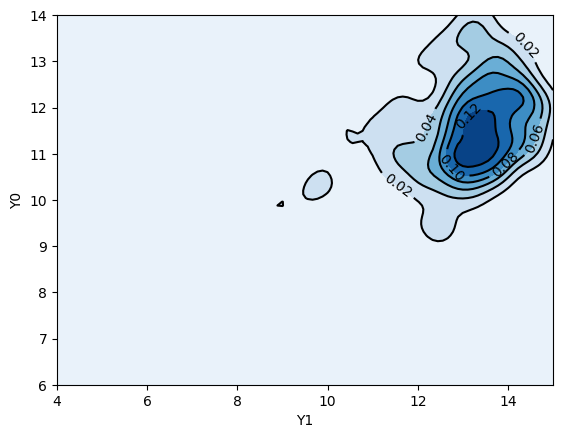

In [22]:
sd.plot_background([[4,15],[6,14]])

In [23]:
super_thinned = sd.super_thinning(sd.prob_background.sum()*.01/sd.T,A =[[4,15],[6,14]])
csr_mnn_test(super_thinned,[[4,15],[6,14]])

Number of simulated points, 216.
 Number of data points 117
Mean Nearest Neighbor Complete Spatial Randomness Test on Super Thinned Points
Z-value: 0.001870777648288446, P-value: 0.9985073362684086


(0.001870777648288446, 0.9985073362684086)

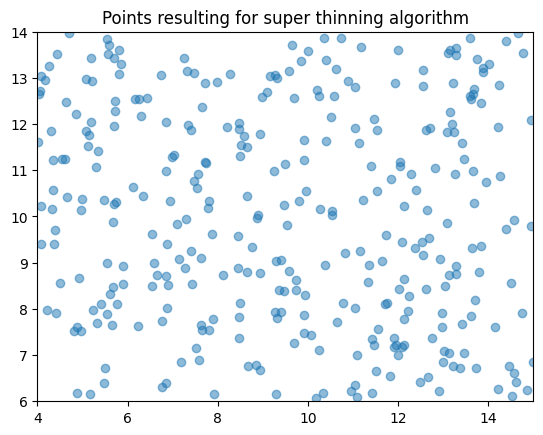

In [24]:
plt.scatter(super_thinned.T[0],super_thinned.T[1],alpha=.5)
plt.xlim(4,15)
plt.ylim(6,14)
plt.title("Points resulting for super thinning algorithm")
plt.show()

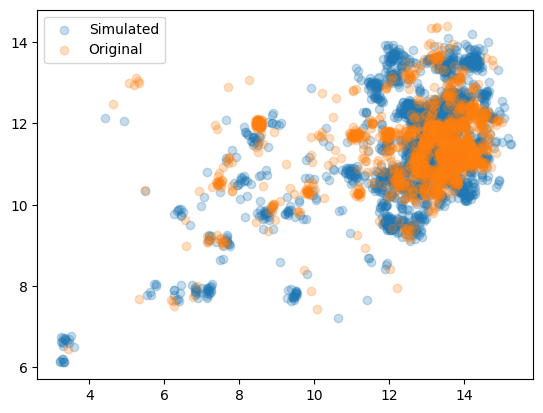

In [26]:
x = sd.simulate()
plt.scatter(x.T[0],x.T[1],alpha=0.25,label='Simulated')
plt.scatter(sd.events.T[0],sd.events.T[1],alpha=0.25,label='Original')
plt.legend()
plt.show()

### Model Checking: Temporal

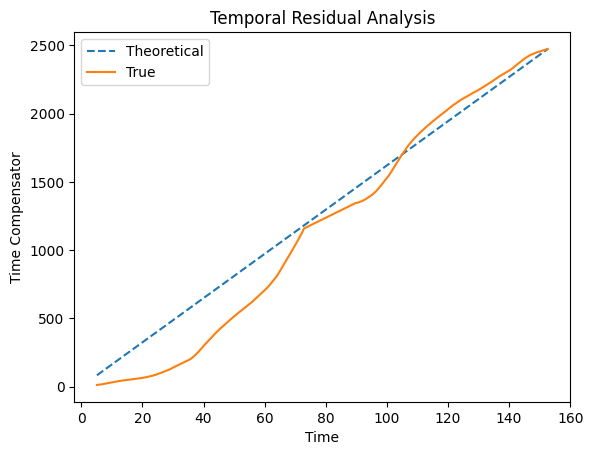

In [10]:
t = np.sort(sd.events.T[2].copy())
t_resid = sd.Lamb_t(t)
plt.plot(t,t*t_resid[-1]/t[-1],linestyle='dashed',label="Theoretical")
plt.plot(t,t_resid,label="True")
plt.ylabel("Time Compensator")
plt.xlabel("Time")
plt.legend()
plt.title("Temporal Residual Analysis")
plt.show()

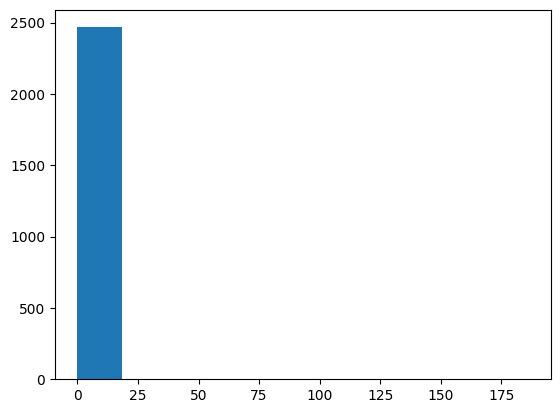

KstestResult(statistic=0.39449169704333736, pvalue=0.0, statistic_location=0.0, statistic_sign=1)

In [11]:
from scipy.stats import kstest
iet = t_resid[1:]-t_resid[:-1]
plt.hist(iet)
plt.show()
kstest(iet,expon.cdf)

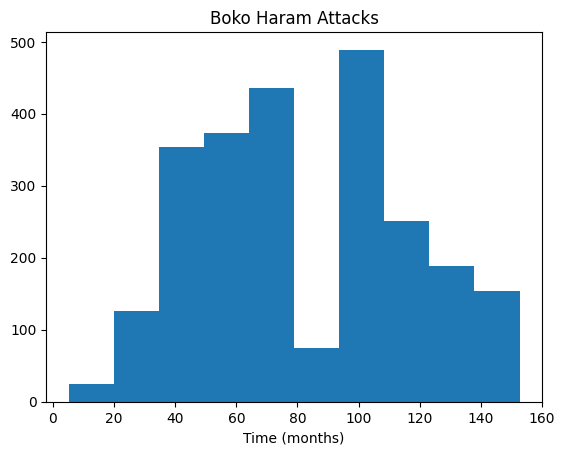

In [25]:
plt.hist(sd.events.T[2])
plt.title("Boko Haram Attacks")
plt.xlabel("Time (months)")
plt.show()

## With Marks

In [2]:
from sd_marks import *

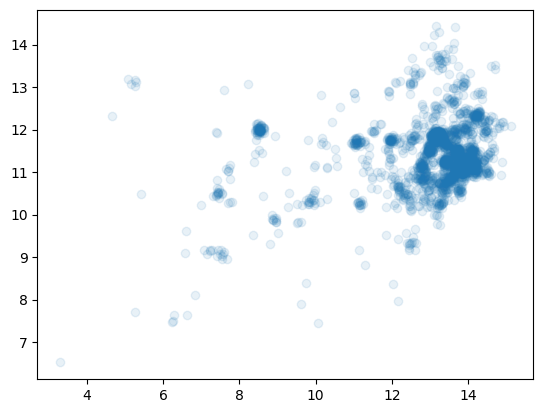

In [5]:
dat = pd.read_csv('../Data/BH_violence.csv')
bh = "Jama'atu Ahlis Sunna Lidda'awati wal-Jihad"
dat['opponent'] = dat.side_a.copy()
dat.loc[dat.side_a==bh,'opponent'] = dat.side_b[dat.side_a==bh]
X = dat[['longitude','latitude','date_start','best','opponent']].values
X.T[0] = X.T[0] + np.random.normal(scale=4/69,size=len(X))
X.T[1] = X.T[1] + np.random.normal(scale=4/69,size=len(X))
X.T[3] = X.T[3]**0.5
X.T[4] = X.T[4]=='Civilians'
X = X.astype(float)
plt.scatter(X.T[0],X.T[1],alpha=0.1)
plt.show()

In [6]:
par_0 = np.array([.8,2.75,.1,.1]+[0]*(X.shape[1]-3))
T = X.T[2].max()
sd = stochastic_declustering_marks(X,T=T,iht=True)
sd.fit(par_0,A=[[4,15],[6,14]])

Optimization terminated successfully.
         Current function value: -2307.700872
         Iterations: 450
         Function evaluations: 711
MLE time 423.9880850315094
Finished MLE
[ 8.56298388e-01  2.92601917e+00  7.09382458e-02  6.72717042e-02
 -7.23733843e-03 -1.98362173e-03]
Change in parameters: 0.03549847558587572
Optimization terminated successfully.
         Current function value: -2317.343327
         Iterations: 449
         Function evaluations: 699
MLE time 420.9714403152466
Finished MLE
[ 0.85526375  2.96948621  0.07032567  0.06660999 -0.00845397 -0.00358924]
Change in parameters: 0.0018953252806170296


array([ 0.85526375,  2.96948621,  0.07032567,  0.06660999, -0.00845397,
       -0.00358924])

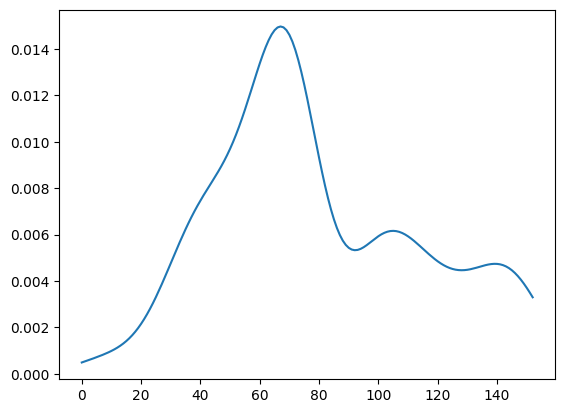

In [7]:
x = np.arange(0,sd.T,1)
y = np.exp(sd.tkde.score_samples(x.reshape(-1,1)))
plt.plot(x,y)
plt.show()

In [6]:
f"AIC: {2*len(sd.parameters) - 2*(2319.749879 - sd.prob_background.sum())}"

'AIC: -3835.0958294461598'

In [10]:
S = sd.wald()

In [13]:
from scipy.stats import chi2
par_names = ['r_0','b','s1','s2','a1','a2']
def test(i):
    p_val = 1-chi2.cdf((sd.parameters[i])**2/S[i,i],1)
    MOE = (chi2.ppf(0.975,1)*S[i,i])**0.5
    CI = (sd.parameters[i]-MOE,sd.parameters[i]+MOE)
    print(f"p-value for (H_0: {par_names[i]}=0):{p_val}.\nConfidence interval for {par_names[i]}: {CI}")
test(5)
test(4)

p-value for (H_0: a2=0):0.9615491461640168.
Confidence interval for a2: (-0.17046294627383154, 0.16328447199601778)
p-value for (H_0: a1=0):0.5875912879856773.
Confidence interval for a1: (-0.043393495871540295, 0.026485558169021046)


In [8]:
import pickle
with open('models/bokoharam_sdm_iht.o','wb') as f:
    pickle.dump(sd,f)

In [4]:
import pickle
with open('models/bokoharam_sdm.o','rb') as f:
    sd = pickle.load(f)

## Issues with Stochastic Declustering

A significant issue with stochastic declustering manifested itself in the fitting of the earthquake data and the Mexican terrorism data. Both datasets had highly clustered backgrounds. It is well known that kernel density underestimates sharp peaks. Because of this bias in the kernel density estimation, the model had to attribute the large number of points in a localized area to self excitation. These points were not temporally clustered, however, so the time scale in the triggering function will be enlarged. The end result is an artificially high $r_0$ and $\beta$ and lower background estimation at highly clustered locations. Adaptive bandwidth schemes may improve this issue.

Additionally, inhomogeneity in time must be completely described by self-excitation. The Boko Haram terrorist data, however, includes a significant amount of temporal clustering that is not the result of self-excitation. There were indeed political and military changes during this time, that affected terrorism activity. Because of this temporal clustering $r_0$ is artificially high.

Further, explanatory variables (like distanct to fault line for earthquakes, and population density for Mexican terrorism, and political changes for Boko Haram terrorism) are not included in the background estimation for stochastic declustering.